# Q-Learning

## Replay Memory

Replay memory stores given `capacity` amount of transitions in a buffer. It provides methods for pushing new transitions and sampling a minibatch.

### Implementation

In [1]:
from collections import deque
import numpy as np

class ReplayMemory(object):
    
    def __init__(self, capacity):
        self.capacity = capacity
        self.clear()
    
    def clear(self):
        self.memory = deque(maxlen=self.capacity)
    
    def push(self, transition):
        self.memory.appendleft(transition)
    
    def sample(self, size, withReplacement=False):
        if size > len(self.memory) and not withReplacement:
            return None
        
        indecies = np.random.choice(len(self.memory), size, replace=withReplacement)
        return np.array(list(self.memory))[indecies]


### Tests

In [2]:
import unittest

class ReplayMemoryTest(unittest.TestCase):
    
    def test_should_drop_oldest_memory_on_overflow(self):
        memory = ReplayMemory(4)
        memory.push(1)
        memory.push(2)
        memory.push(3)
        memory.push(4)
        memory.push(5)
        
        self.assertEqual(list(memory.memory), [5, 4, 3, 2])
        
    def test_should_sample_with_replacement(self):
        memory = ReplayMemory(4)
        memory.push(1)
        memory.push(2)
        memory.push(3)
        memory.push(4)
        
        miniBatch = memory.sample(3, withReplacement=True)
        self.assertEqual(len(miniBatch), 3)
        
        for elem in miniBatch:
            self.assertIn(elem, [1, 2, 3, 4])
            
    def test_should_sample_without_replacement(self):
        memory = ReplayMemory(4)
        memory.push(1)
        memory.push(2)
        memory.push(3)
        memory.push(4)
        
        miniBatch = memory.sample(4, withReplacement=False)
        miniBatch.sort()
        
        self.assertEqual(miniBatch.tolist(), [1, 2, 3, 4])
    
    def test_should_sample_larger_batch_size_with_replacement(self):
        memory = ReplayMemory(4)
        memory.push(1)
        memory.push(2)
        
        miniBatch = memory.sample(4, withReplacement=True)
        
        self.assertEqual(len(miniBatch), 4)
        for elem in miniBatch:
            self.assertIn(elem, [1, 2])
    
    def test_should_return_none_when_spamling_larger_batch_size_without_replacement(self):
        memory = ReplayMemory(4)
        memory.push(1)
        memory.push(2)
        
        miniBatch = memory.sample(4, withReplacement=False)
        self.assertEqual(miniBatch, None)
    
    def test_should_handle_memorizing_multidimensional_arrays(self):
        memory = ReplayMemory(4)
        memory.push([1, 2])
        memory.push([3, 4])
        
        miniBatch = memory.sample(4, withReplacement=True)
        
        self.assertEqual(len(miniBatch), 4)
        for elem in miniBatch:
            self.assertTrue((elem == [1, 2]).all() or (elem == [3, 4]).all())
    
    def test_should_clear_memory(self):
        memory = ReplayMemory(4)
        memory.push(1)
        memory.push(2)
        
        memory.clear()
        self.assertEqual(len(memory.memory), 0)
    
if __name__ == '__main__':
    unittest.main(argv=[''], exit=False)


.......
----------------------------------------------------------------------
Ran 7 tests in 0.025s

OK


## Epsilon Greedy Policy

### Implementation

In [3]:
import numpy as np
import random
from collections import namedtuple

ActionSelections = namedtuple('ActionSelections', ['indecies', 'values'])

class EpsilonGreedyPolicy(object):
    
    def __init__(self, epsilon, random_engine=random):
        self.epsilon = epsilon
        self.random_engine = random_engine
    
    def select_action(self, action_value_functions, force=None):
        if action_value_functions is None or len(action_value_functions) == 0:
            return None
        
        # Used at selection contains row indecies
        row_idx = range(len(action_value_functions))
        
        # Find index of max column for each row
        greedy_actions = np.argmax(action_value_functions, axis=1)

        # Find non greedy actions for each row
        non_greedy_actions = np.random.choice(len(action_value_functions[0]) - 1, len(action_value_functions))
        non_greedy_actions += (non_greedy_actions >= greedy_actions)
        
        if force == 'exploit':
            return ActionSelections(greedy_actions, np.array(action_value_functions)[row_idx, greedy_actions])
        elif force == 'explore':
            return ActionSelections(non_greedy_actions, np.array(action_value_functions)[row_idx, non_greedy_actions])
        
        if self.random_engine.uniform(0, 1) > self.epsilon:
            return ActionSelections(greedy_actions, np.array(action_value_functions)[row_idx, greedy_actions])
        
        return ActionSelections(non_greedy_actions, np.array(action_value_functions)[row_idx, non_greedy_actions])
                                                                                                       

### Tests

In [4]:
from types import SimpleNamespace
import unittest

class EpsilonGreedyPolicyTest(unittest.TestCase):
    
    def test_should_select_greedy_when_forced(self):
        e_greedy = EpsilonGreedyPolicy(0.01)
        selection = e_greedy.select_action([[0.1, 0.4, 0.2], [0.9, 0.5, 0.1]], force='exploit')
        np.testing.assert_allclose(selection.indecies, [1, 0])
        np.testing.assert_allclose(selection.values, [0.4, 0.9])
        
    def test_should_select_explore_when_forced(self):
        e_greedy = EpsilonGreedyPolicy(0.01)
        selection = e_greedy.select_action([[0.1, 0.4, 0.2], [0.9, 0.5, 0.1]], force='explore')
        
        self.assertIn(selection.indecies[0], [0, 2])
        self.assertIn(selection.indecies[1], [1, 2])
        
        self.assertIn(selection.values[0], [0.1, 0.2])
        self.assertIn(selection.values[1], [0.5, 0.1])
    
    def test_should_select_greedy_when_random_is_higher_than_epsilon(self):
        e_greedy = EpsilonGreedyPolicy(0.1, random_engine=SimpleNamespace(uniform=lambda a, b: 0.2))
        selection = e_greedy.select_action([[0.1, 0.4, 0.2], [0.9, 0.5, 0.1]])
        np.testing.assert_allclose(selection.indecies, [1, 0])
        np.testing.assert_allclose(selection.values, [0.4, 0.9])
    
    def test_should_select_eploratively_when_random_is_higher_than_epsilon(self):
        e_greedy = EpsilonGreedyPolicy(0.1, random_engine=SimpleNamespace(uniform=lambda a, b: 0.05))
        selection = e_greedy.select_action([[0.1, 0.4, 0.2], [0.9, 0.5, 0.1]])
        
        self.assertIn(selection.indecies[0], [0, 2])
        self.assertIn(selection.indecies[1], [1, 2])
        
        self.assertIn(selection.values[0], [0.1, 0.2])
        self.assertIn(selection.values[1], [0.5, 0.1])

    def test_should_return_none_with_empty_action_value_functions(self):
        e_greedy = EpsilonGreedyPolicy(0.01)
        self.assertEqual(e_greedy.select_action([], force='exploit'), None)
        
if __name__ == '__main__':
    unittest.main(argv=[''], exit=False)


............
----------------------------------------------------------------------
Ran 12 tests in 0.091s

OK


## Environment Loop

### Implementation

In [5]:
import time
from tqdm.notebook import tqdm

def env_loop(env, agent, episodes, render=False, max_steps_per_episode=None):
    rewards = []
    actions = []
    
    for i_episode in tqdm(range(episodes), desc='episode'):
        episode_rewards = 0
        episode_actions = []
        
        # Initialize the environment and state for the episode
        state_t = env.reset()
        
        i_episode_step = 0
        done = False
        
        while not done and (max_steps_per_episode is None or max_steps_per_episode > i_episode_step):
            if render:
                env.render()
                time.sleep(0.1)
            
            action_t = agent.select_action(state_t)
            state_t1, reward_t, done, _ = env.step(action_t)
            
            agent.observe([state_t, action_t, reward_t, state_t1])
            
            episode_rewards += reward_t
            episode_actions.append(action_t)
            
            state_t = state_t1
            i_episode_step += 1
        
        rewards.append(episode_rewards)
        actions.append(episode_actions)
    
    return np.array(rewards), actions

### Tests

## Deep Q-Network

### Implementation

In [6]:
import torch
import torch.nn as nn

class DeepQNetwork(nn.Module):
    
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(DeepQNetwork, self).__init__()
        
        self.hidden_layer = nn.Linear(input_dim, hidden_dim)
        self.hidden_activation_fn = nn.Sigmoid()
        
        self.output_layer = nn.Linear(hidden_dim, output_dim)
        self.output_layer_activation_fn = nn.Sigmoid()
        
    def forward(self, input_features):
        hidden_output = self.hidden_layer(input_features)
        hidden_activation = self.hidden_activation_fn(hidden_output)
        
        output_output = self.output_layer(hidden_activation)
        return self.output_layer_activation_fn(output_output)

### Tests

In [7]:
import unittest

class DeepQNetworkTest(unittest.TestCase):
    
    def test_should_perform_forward_pass(self):
        input_features = torch.randn(3, 4)
        
        deep_q = DeepQNetwork(4, 20, 5)
        output = deep_q(input_features)
        
        self.assertEqual(output.size(), (3, 5))

if __name__ == '__main__':
    unittest.main(argv=[''], exit=False)


.............
----------------------------------------------------------------------
Ran 13 tests in 0.037s

OK


## Agent

### Implementation

In [8]:
from collections import namedtuple
import torch

TrainParams = namedtuple('TrainParams', ['batch_size', 'learning_rate', 'target_update_interval', 'Optimizer'])
PolicyParams = namedtuple('PolicyParams', ['e_greedy', 'memory', 'discount_factor', 'make_qnet'])

class Agent(object):
    
    def __init__(self, trainParams, policyParams):
        self.e_greedy = policyParams.e_greedy
        self.q_net = policyParams.make_qnet()
        
        self.memory = policyParams.memory
        self.discount_factor = policyParams.discount_factor
        self.target_update_interval = trainParams.target_update_interval
        
        self.batch_size = trainParams.batch_size
        self.learning_rate = trainParams.learning_rate
        self.Optimizer = trainParams.Optimizer
        
        self.make_qnet = policyParams.make_qnet
        
        self.state = 'eval'
    
    def set_state(self, state):
        if self.state == state or state not in ['train', 'eval']:
            return
        
        if state == 'train':
            self._init_train()
        
        self.state = state
    
    def select_action(self, state):
        action_values = self.q_net(torch.tensor(state).float())
        action = self.e_greedy.select_action([action_values.detach().numpy()], force='exploit' if self.state == 'eval' else None).indecies[0]
        return action
    
    def observe(self, transition):
        # No need to do anything unless is training
        if self.state != 'train':
            return
        
        # Store observed transition to memory
        self.memory.push(transition)
        
        # Sample minibatch from memory
        batch = self.memory.sample(self.batch_size)
        
        # Don't train until has enough samples
        if batch is None:
            return
        
        # Unpack batch
        [batch_state_t, batch_action_t, batch_reward_t, batch_state_t1] = batch.T
        batch_state_t = np.concatenate(batch_state_t).reshape((-1, 4))
        batch_action_t = batch_action_t.astype(np.int32, copy=False)
        batch_reward_t = batch_reward_t.astype(np.float32, copy=False)
        batch_state_t1 = np.concatenate(batch_state_t1).reshape((-1, 4))
        
        # Calculate target action values for minibatch
        target_action_value_estimates = self.q_net_target(torch.tensor(batch_state_t1).float()).detach().numpy()
        y = batch_reward_t + self.discount_factor * self.e_greedy.select_action(target_action_value_estimates, force='exploit').values
        
        # Reset gradients for training step
        self.optimizer.zero_grad()
        
        # Calculate action values using Q for minibatch
        action_value_estimates = self.q_net(torch.tensor(batch_state_t).float())
        
        # Select action values based on the taken actions
        x = action_value_estimates[range(len(action_value_estimates)), batch_action_t]
        
        # Calculate loss and update weights of Q
        loss = self.loss_fn(x, torch.from_numpy(y))
        loss.backward()
        self.optimizer.step()
        
        # Every target_update_interval update Q- with weights of Q
        if self.train_step % self.target_update_interval == 0:
            self.q_net_target.load_state_dict(self.q_net.state_dict())
            self.q_net_target.eval()
            
        # Update training step
        self.train_step += 1
    
    def _init_train(self):
        # Clear memory from previous training
        self.memory.clear()
        
        # Make target network, initialize its weights to match Q network weights and set it to eval mode
        self.q_net_target = self.make_qnet()
        self.q_net_target.load_state_dict(self.q_net.state_dict())
        self.q_net_target.eval()
    
        # Loss function is MSE
        self.loss_fn = nn.MSELoss()
        self.optimizer = self.Optimizer(self.q_net.parameters(), self.learning_rate)
    
        self.train_step = 0
        

## Random Agent Baseline

## Train Agent

In [9]:
def make_qnet_fn(env):
    return lambda: DeepQNetwork(env.observation_space.shape[0], 20, env.action_space.n)


baseline actions: [[1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1], [1, 1, 1, 1, 1, 0, 1, 0, 1, 0], [1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1], [1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0], [1, 1, 1, 1, 1, 0, 1, 0, 1, 0], [1, 1, 1, 1, 1, 1, 0, 1, 0, 0], [1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0], [1, 1, 1, 1, 1, 0, 1, 0, 1, 0], [1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1], [1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1]]
baseline rewards: [11. 10. 11. 12. 10. 10. 11. 10. 11. 11.]


<ipython-input-1-8084a1b09446>:21: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array(list(self.memory))[indecies]


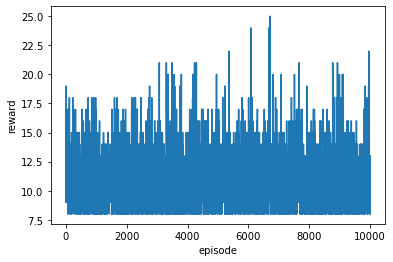


preview rewards: [ 9.  9.  8.  9. 10.  8. 10. 10. 10.  9.]
preview actions: [[1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1]]


In [10]:
import gym
import torch.optim as optim
import matplotlib.pyplot as plt

# Set hyper-parameters
# Replay Memory Capacity
N = 50

train_episodes = 10000
preview_episodes = 10

batch_size = 20
learning_rate = 0.001
target_update_interval = 8

# Create environment
env = gym.make('CartPole-v0')

# Create agent
trainParams = TrainParams(batch_size, learning_rate, target_update_interval, optim.SGD)
policyParams = PolicyParams(EpsilonGreedyPolicy(0.1), ReplayMemory(N), 0.9, make_qnet_fn(env))
agent = Agent(trainParams, policyParams)

# Get agent baseline
agent.set_state('eval')
baseline_rewards, baseline_actions = env_loop(env, agent, preview_episodes, render=False, max_steps_per_episode=200)
print(f'baseline actions: {baseline_actions}')
print(f'baseline rewards: {baseline_rewards}')

# Train in env environment
agent.set_state('train')
train_rewards, train_actions = env_loop(env, agent, train_episodes, render=False, max_steps_per_episode=200)

# Visualize training
plt.plot(list(range(len(train_rewards))), train_rewards)
plt.xlabel('episode')
plt.ylabel('reward')
plt.show()

# Preview learned agent
agent.set_state('eval')
preview_rewards, preview_actions = env_loop(env, agent, preview_episodes, render=True, max_steps_per_episode=200)
print(f'preview rewards: {preview_rewards}')
print(f'preview actions: {preview_actions}')

# Close environment
env.close()